## Mnist Dataset Classification using K-Nearest Neighbors (Euclidean)

### Summary
<img align="right" src="../image/NearestNeighbor.png" width=150 height=150>
KNN은 새로운 데이터가 주어졌을 때 기존 데이터 가운데 가장 가까운 k개 이웃의 정보로 새로운 데이터를 예측하는 알고리즘

새로운 데이터가 주어진 경우 기존 모든 데이터와의 거리를 계산한다. 계산된 거리 값이 작은 k개의 데이터를 선정한다. 새로운 데이터의 클래스는 선정된 데이터들의 클래스 중 가장 많이 선택된 클래스로 분류한다.

거리 계산 방법에는 Euclidean, Mahalanobis 등 있다.

Mnist 데이터셋을 이용하여 0부터 9까지의 10가지 손글씨 클래스를 구분한다. 거리 계산 방법은 Euclidean을 사용한다.

Time 측정 방법은 Method 측면에서는 
1. Model Fitting Time : KNN의 경우 데이터셋에 대한 Checking 및 데이터셋 메모리에 카피
2. All Test Data Prediction Time
3. One Instance Prediction Time

PCA 측면에서는 
1. Calculating U x S x Vt Matrix Time
2. Calculating new X = U x S Matrix Time

In [16]:
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [9]:
class BaseConfig:
    def __init__(self):
        pass

    def info(self):
        config_list = {
            0 : ['Dataset', self.dataset, 
                 "Train size: " + str(int((1-self.test_size)*100))+"%",
                 'Feature size: ' + str(self.feature_size), 1],
            1 : ['Method', self.method, 
                 "k = " + str(self.k), self.distance, 2],
            2 : ['Dimension reduction', 
                 'Method: ' + str(self.reduction_method[0]),
                 'Component size: ' + str(self.reduction_method[1]),
                 'Feature Reduction Ratio: ' + \
                    str(round(self.reduction_method[1]/self.feature_size, 3)*100 if self.reduction_method[1] is not None else None)+"%", 3],
            3 : ['Iteration', str(self.iter), -1]
        }

        print("Device " + "─" * 2 + " " + self.device)
        print("│")

        parent = 1
        for child in range(len(config_list)):
            for idx, contents in enumerate(config_list[child][:-1]):
                if idx == 0 and child == len(config_list)-1:
                    print("└" + "─" * 2 + contents)
                elif idx == 0:
                    print("├" + "─" * 2 + contents)
                elif child == len(config_list)-1:
                    print(" " * 4 + "└" + "─" * 4 + contents)
                else:
                    print("│" + " " * 4 + "└" + "─" * 4 + contents)
            parent = config_list[child][-1]
            if parent == -1: break
            print("│")

class Config(BaseConfig):
    def __init__(self):
        super(BaseConfig, self).__init__()
        self.device = 'Jetson'
        self.dataset = 'Mnist'
        self.test_size = 0.2
        self.feature_size = 784
        self.method = 'kNN'
        self.k = 1
        self.distance = 'Euclidean'
        self.reduction_method = [None, None] # method, n_components
        self.iter = 10


# Load Mnist Dataset

In [2]:
mnist = fetch_openml('mnist_784', version=1)

print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [3]:
X, y = mnist["data"], mnist["target"]
X = X / 255.
y = y.astype(np.int64)
print(f'Mnist Data range [{X.to_numpy().min()}, {X.to_numpy().max()}] ')
print(f'Mnist Data shape X: {X.shape}, y: {y.shape}')

Mnist Data range [0.0, 1.0] 
Mnist Data shape X: (70000, 784), y: (70000,)


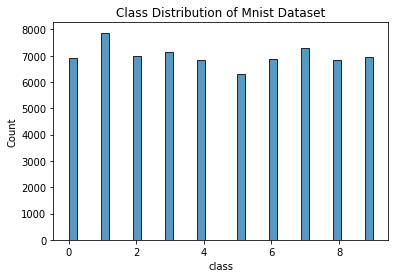

In [4]:
sns.histplot(y, palette="tab10")
plt.title("Class Distribution of Mnist Dataset")
plt.show()

## K-Nearest Neighbor

In [10]:
config = Config()
config.info()

Device ── Jetson
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 1
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: None
│    └────Component size: None
│    └────Feature Reduction Ratio: None%
│
└──Iteration
    └────10


In [5]:
avg_test_acc = []
avg_knn_fit_time = []
avg_pred_time = []

max_seed = 10

for seed in tqdm(range(max_seed)):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)

    k = 1

    knn = KNeighborsClassifier(k, weights='distance', n_jobs=-1)
    start_time = time.perf_counter()
    knn.fit(x_train, y_train)
    knn_fit_time = time.perf_counter() - start_time
    avg_knn_fit_time.append(knn_fit_time)

    start_time = time.perf_counter()
    pred = knn.predict(x_test)
    pred_time = time.perf_counter() - start_time

    test_score = accuracy_score(pred, y_test)
    avg_test_acc.append(test_score)
    avg_pred_time.append(pred_time)

print("Train size : ", len(x_train), " / Test size : ", len(x_test))
print("-----" * 8)
print("Test set score: %f" % np.array(avg_test_acc).mean())
print("KNN fitting Time: %.4f ± %.5f" % (np.array(avg_knn_fit_time).mean(), np.array(avg_knn_fit_time).std()), "sec")
print("All Test dataset Prediction Time at once : %.4f ± %.5f" % (np.array(avg_pred_time).mean(), np.array(avg_pred_time).std()), "sec")
print("Divide the Prediction Time by Test size : %.8f ± %.8f" % (np.array(avg_pred_time).mean()/len(x_test)*1e6, np.array(avg_pred_time).std()/len(x_test)*1e6), "microsec")

100%|██████████| 10/10 [1:50:04<00:00, 660.40s/it]


Train size :  56000  / Test size :  14000
----------------------------------------
Test set score: 0.972400
KNN fitting Time: 0.3039 ± 0.15850 sec
All Test dataset Prediction Time at once : 628.5791 ± 113.56097 sec
Divide the Prediction Time by Test size : 44898.50709029 ± 8111.49813524 microsec


### 1개의 Instance를 예측하는데 걸리는 시간 측정 - 1000번 반복

In [13]:
knn = KNeighborsClassifier(k, weights='distance', n_jobs=-1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)

x_train, x_test = x_train.to_numpy(), x_test.to_numpy()
y_train, y_test = np.array(y_train).reshape(-1, 1), np.array(y_test).reshape(-1, 1)


knn.fit(x_train, y_train)

avg_test_score = []
avg_pred_time = []
count = 0

for x_one, y_one in tqdm(zip(x_test, y_test)):
    x_one = x_one.reshape(1, -1)

    start = time.perf_counter()
    pred = knn.predict(x_one)
    pred_time = time.perf_counter() - start
    
    test_score = accuracy_score(pred, y_one)

    avg_test_score.append(test_score)
    avg_pred_time.append(pred_time)

    count += 1
    if count == 1000:
        break

print("Train size : ", len(x_train), " / Test size : ", 1000)
print("-----" * 8)
print("Test set score: %f" % np.array(avg_test_score).mean())
print("One Instance Prediction Average Time : %.8f ± %.8f" % (np.array(avg_pred_time).mean(), np.array(avg_pred_time).std()), "microsec")

/home/ai/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
999it [07:01,  2.37it/s]

Train size :  56000  / Test size :  1000
----------------------------------------
Test set score: 0.968000
One Instance Prediction Average Time : 0.41616983 ± 0.03939431 microsec


### kNN with PCA feature 2

In [26]:
config.reduction_method = ['PCA', 2]
config.k = 2
config.info()

Device ── Jetson
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 2
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 2
│    └────Feature Reduction Ratio: 0.3%
│
└──Iteration
    └────10


### Time of calculating PCA

In [23]:
n_components = 2

pca_dims = PCA(n_components)
print(f"The number of components : {n_components}")

start_time = time.perf_counter()
pca_dims.fit(X)
pca_fit_time = time.perf_counter () - start_time
print(f"Calculating U*S*Vt Matrix Time: {pca_fit_time:4f} sec")

start_time = time.perf_counter()
features = pca_dims.transform(X)
features_extract_time = time.perf_counter () - start_time
print(f"Calculating new X = U*S Matrix Time: {features_extract_time:4f} sec")

The number of components : 2
Calculating U*S*Vt Matrix Time: 58.759853 sec
Calculating new X = U*S Matrix Time: 11.740884 sec


In [28]:
avg_test_acc = []
avg_knn_fit_time = []
avg_pred_time = []

max_seed = 10

for seed in tqdm(range(max_seed)):
    x_train, x_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=seed, shuffle=True)

    k = 2

    knn = KNeighborsClassifier(k, weights='distance', n_jobs=-1)
    start_time = time.perf_counter()
    knn.fit(x_train, y_train)
    knn_fit_time = time.perf_counter() - start_time
    avg_knn_fit_time.append(knn_fit_time)

    start_time = time.perf_counter()
    pred = knn.predict(x_test)
    pred_time = time.perf_counter() - start_time

    test_score = accuracy_score(pred, y_test)
    avg_test_acc.append(test_score)
    avg_pred_time.append(pred_time)

print("Train size : ", len(x_train), " / Test size : ", len(x_test))
print("-----" * 8)
print("Test set score: %f" % np.array(avg_test_acc).mean())
print("KNN fitting Time: %.4f ± %.5f" % (np.array(avg_knn_fit_time).mean(), np.array(avg_knn_fit_time).std()), "sec")
print("All Test dataset Prediction Time at once : %.4f ± %.5f" % (np.array(avg_pred_time).mean(), np.array(avg_pred_time).std()), "sec")
print("Divide the Prediction Time by Test size : %.8f ± %.8f" % (np.array(avg_pred_time).mean()/len(x_test)*1e6, np.array(avg_pred_time).std()/len(x_test)*1e6), "microsec")

### kNN with PCA feature 3

In [24]:
config.reduction_method = ['PCA', 3]
config.k = 3
config.info()

Device ── Jetson
│
├──Dataset
│    └────Mnist
│    └────Train size: 80%
│    └────Feature size: 784
│
├──Method
│    └────kNN
│    └────k = 1
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 3
│    └────Feature Reduction Ratio: 0.4%
│
└──Iteration
    └────10


### Time of calculating PCA

In [25]:
n_components = 3

pca_dims = PCA(n_components)
print(f"The number of components : {n_components}")

start_time = time.perf_counter()
pca_dims.fit(X)
pca_fit_time = time.perf_counter () - start_time
print(f"Calculating U*S*Vt Matrix Time: {pca_fit_time:4f} sec")

start_time = time.perf_counter()
features = pca_dims.transform(X)
features_extract_time = time.perf_counter () - start_time
print(f"Calculating new X = U*S Matrix Time: {features_extract_time:4f} sec")

The number of components : 3
Calculating U*S*Vt Matrix Time: 27.899060 sec
Calculating new X = U*S Matrix Time: 1.389734 sec


In [ ]:
avg_test_acc = []
avg_knn_fit_time = []
avg_pred_time = []

max_seed = 10

for seed in tqdm(range(max_seed)):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)

    k = 3

    knn = KNeighborsClassifier(k, weights='distance', n_jobs=-1)
    start_time = time.perf_counter()
    knn.fit(x_train, y_train)
    knn_fit_time = time.perf_counter() - start_time
    avg_knn_fit_time.append(knn_fit_time)

    start_time = time.perf_counter()
    pred = knn.predict(x_test)
    pred_time = time.perf_counter() - start_time

    test_score = accuracy_score(pred, y_test)
    avg_test_acc.append(test_score)
    avg_pred_time.append(pred_time)

print("Train size : ", len(x_train), " / Test size : ", len(x_test))
print("-----" * 8)
print("Test set score: %f" % np.array(avg_test_acc).mean())
print("KNN fitting Time: %.4f ± %.5f" % (np.array(avg_knn_fit_time).mean(), np.array(avg_knn_fit_time).std()), "sec")
print("All Test dataset Prediction Time at once : %.4f ± %.5f" % (np.array(avg_pred_time).mean(), np.array(avg_pred_time).std()), "sec")
print("Divide the Prediction Time by Test size : %.8f ± %.8f" % (np.array(avg_pred_time).mean()/len(x_test)*1e6, np.array(avg_pred_time).std()/len(x_test)*1e6), "microsec")